Notebook used for producing the plots for Osborne & Fletcher 2022 (Flare Kernels May Be Smaller Than You Think), including tonemapping code. Some additional data from my thesis distribution may be needed. This variant investigates line formation around the $\tau_\nu=1$ region.

In [1]:
%matplotlib widget
import numpy as np
import zarr
import matplotlib.pyplot as plt
import lightweaver as lw
from lightweaver import LwCompiled
import pickle

import os
import sys
sys.path.append(f'{os.environ["HOME"]}/MsLightweaver2d/')
from MsLightweaverAtoms import H_6, CaII
from lightweaver.rh_atoms import H_6_atom, C_atom, O_atom, OI_ord_atom, Si_atom, Al_atom, Fe_atom, FeI_atom, MgII_atom, N_atom, Na_atom, S_atom, CaII_atom, He_9_atom
from MsLightweaver2dFixedIlluminationManager import *
from ReadAtmost import read_atmost
from functools import partial
from weno4 import weno4
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
FastBackground = partial(LwCompiled.FastBackground, Nthreads=32)

In [3]:
rad_path = 'F10_flat_450_41_nr_1stColCopy_besser_qsbc_radiation_thesis.zip'
radF9_path = 'F9_flat_450_41_nr_1stColCopy_besser_qsbc_radiation_thesis.zip'
pops_path = 'F10_flat_450_41_nr_1stColCopy_besser_qsbc_pops_thesis.zip'
popsF9_path = 'F9_flat_450_41_nr_1stColCopy_besser_qsbc_pops_thesis.zip'
atmost_path = 'Flat1e10/atmost.dat' 
atmost_path = '/home/goobley/Thesis/Data/03TwoDRT/atmost_F10.dat' 
atmost_path = '/Users/goobley/Thesis/Data/03TwoDRT/atmost_F10.dat'
atmostF9_path = '/Users/goobley/Thesis/Data/03TwoDRT/atmost_F9.dat'
rad = zarr.convenience.open(rad_path, 'r')
radF9 = zarr.convenience.open(radF9_path, 'r')
pops = zarr.convenience.open(pops_path, 'r')
popsF9 = zarr.convenience.open(popsF9_path, 'r')
atmost = read_atmost(atmost_path)
atmost.to_SI()
atmostF9 = read_atmost(atmostF9_path)
atmostF9.to_SI()
# nHTotRadyn = atmost.d1 / (lw.DefaultAtomicAbundance.massPerH * lw.Amu)

In [4]:
list(rad.keys())

['I', 'mux', 'muz', 'time', 'wavelength', 'xAxis']

In [ ]:
list(pops.keys())

In [ ]:
pops['zAxis'].shape

In [5]:
def load_atmos(pops, tIdx):
    time = pops['time'][tIdx]
    atmostIdx = np.searchsorted(atmost.time, time)
    zN = np.copy(pops['zAxis'][tIdx, :])
    atmos = lw.Atmosphere.make_2d(height=zN, x=np.copy(pops['xAxis'][...]),
                                  temperature=np.ones((450, 41)) * weno4(zN, atmost.z1[0], atmost.tg1[0])[:, None],
                                  vx=np.zeros((450, 41)),
                                  vz=np.zeros((450, 41)), 
                                  vturb=np.ones((450, 41))*2e3,
                                  nHTot=np.ones((450, 41)) * weno4(zN, atmost.z1[0], nHTotRadyn[0])[:, None],
                                  ne=np.copy(pops['ne'][tIdx, ...]),
                                  xLowerBc=FixedXBc('lower'),
                                  xUpperBc=FixedXBc('upper'))
    atmos2d = atmos.dimensioned_view()
    atmos2d.temperature[:, 0] = weno4(zN, atmost.z1[atmostIdx], atmost.tg1[atmostIdx])
    atmos2d.vz[:, 0] = weno4(zN, atmost.z1[atmostIdx], atmost.vz1[atmostIdx])
    atmos2d.nHTot[:, 0] = weno4(zN, atmost.z1[atmostIdx], nHTotRadyn[atmostIdx])
    return atmos

In [83]:
atmos = load_atmos(pops, 20)

NameError: name 'nHTotRadyn' is not defined

In [6]:
def make_1d_bc(pops, tIdx, mus):
    time = pops['time'][tIdx]
    atmostIdx = np.searchsorted(atmost.time, time)
    zN = np.copy(pops['zAxis'][tIdx, :])
    atmos = lw.Atmosphere.make_1d(scale=lw.ScaleType.Geometric, depthScale=zN,
                                  temperature=weno4(zN, atmost.z1[atmostIdx], atmost.tg1[atmostIdx]),
                                  vlos=weno4(zN, atmost.z1[atmostIdx], atmost.vz1[atmostIdx]),
                                  vturb=np.ones(450)*2e3,
                                  nHTot=weno4(zN, atmost.z1[atmostIdx], nHTotRadyn[atmostIdx]),
                                  ne=np.copy(pops['ne'][tIdx].reshape(450, 41)[:, 0]))
    atmos.rays(**mus)
    FchromaAtoms = [H_6(), CaII(), He_9_atom(), C_atom(), O_atom(), Si_atom(), Fe_atom(),
                    MgII_atom(), N_atom(), Na_atom(), S_atom()]
    aSet = lw.RadiativeSet(FchromaAtoms)
    aSet.set_active('H', 'Ca')
    spect = aSet.compute_wavelength_grid()
    eqPops = aSet.compute_eq_pops(atmos)
    for ele in ['H', 'Ca']:
        aPop = eqPops[ele]
        aPop[:] = pops[ele][tIdx].reshape(-1, 450, 41)[:, :, 0]
    atmos.hPops = eqPops['H']
    atmos.bHeat = np.zeros(450)
    
    ctx = lw.Context(atmos, spect, eqPops, Nthreads=8, backgroundProvider=FastBackground)
    ctx.depthData.fill = True
    ctx.formal_sol_gamma_matrices()
    return ctx.depthData.I
    
    
def make_ctx(pops, tIdx, mus=None):
    atmos = load_atmos(pops, tIdx)
    if mus is None:
        atmos.rays(muz=1.0, wmu=[1.0])
    else:
        atmos.rays(**mus)
    FchromaAtoms = [H_6(), CaII(), He_9_atom(), C_atom(), O_atom(), Si_atom(), Fe_atom(),
                    MgII_atom(), N_atom(), Na_atom(), S_atom()]
    aSet = lw.RadiativeSet(FchromaAtoms)
    aSet.set_active('H', 'Ca')
    spect = aSet.compute_wavelength_grid()
    eqPops = aSet.compute_eq_pops(atmos)
    for ele in ['H', 'Ca']:
        aPop = eqPops[ele]
        aPop[:] = pops[ele][tIdx]

    ctx = lw.Context(atmos, spect, eqPops, Nthreads=32, backgroundProvider=FastBackground)
    if mus is None:
        atmos.xLowerBc.set_bc(np.zeros((spect.wavelength.shape[0], 450)))
    else:
        bc = make_1d_bc(pops, tIdx, mus)
        atmos.xLowerBc.set_bc(bc[:, :, 1, :])
    atmos.xUpperBc.set_bc(np.zeros((spect.wavelength.shape[0], 450)))
        
    return ctx

In [ ]:
Iverts = []
for tIdx in tqdm(range(pops['time'].shape[0])):
    ctx = make_ctx(pops, tIdx)
    ctx.formal_sol()
    Iverts.append(np.copy(ctx.spect.I))

In [ ]:
# with open('F10_flat_Ivert.pickle', 'wb') as pkl:
#     pickle.dump({'Iverts': Iverts}, pkl)

In [ ]:
plt.figure()
plt.plot(ctx.spect.wavelength, Iverts[50])
plt.xlim(656.271, 656.671)

In [ ]:
muz = rad['muz'][1]
mux = rad['mux'][1]
muy = np.sqrt(1.0 - muz**2 - mux**2)
wmu = 1.0
mus = {'muz': [muz], 'mux': [mux], 'muy': [muy], 'wmu': [wmu]}

Itilt = []
for tIdx in tqdm(range(pops['time'].shape[0])):
    ctx = make_ctx(tIdx, mus=mus)
    ctx.formal_sol()
    Itilt.append(np.copy(ctx.spect.I))

In [7]:
with open('F10_flat_Itilt.pickle', 'rb') as pkl:
    Itilt = pickle.load(pkl)['Itilt']
with open('F10_flat_Ivert.pickle', 'rb') as pkl:
    Iverts = pickle.load(pkl)['Iverts']
with open('F9_flat_Ivert.pickle', 'rb') as pkl:
    IvertsF9 = pickle.load(pkl)['Iverts']

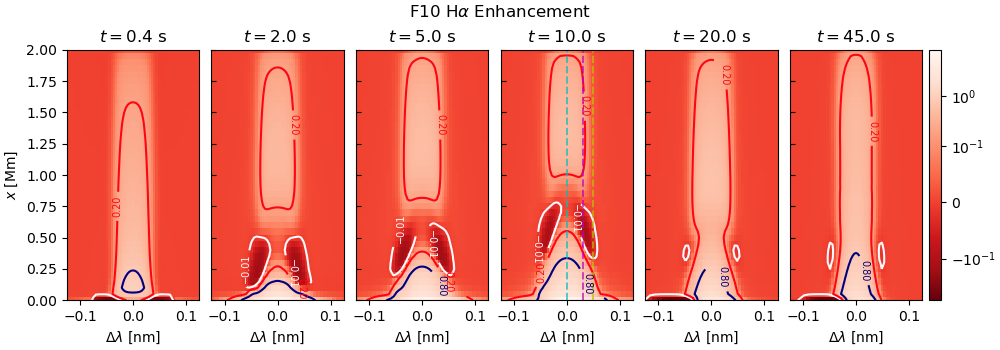

In [8]:
from matplotlib.colors import SymLogNorm
def plot_Iverts(Iverts, idxs, lambda0, deltaLambda, contourLevels=None, figsize=(10, 3.5), wavelengthOffsets=None, title=r'F10 H$\alpha$'):
    wavelengthEdges = np.concatenate([[0.0], 0.5 * (rad['wavelength'][1:] + rad['wavelength'][:-1]), [rad['wavelength'][-1]]])
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]])
    fig, ax = plt.subplots(1, len(idxs), constrained_layout=True, figsize=figsize)
    if contourLevels is None:
        contourLevels = [-0.01, 0.2, 0.4]
        
    if wavelengthOffsets is None:
        wavelengthOffsets = [0.0, 0.03, 0.05]
    offsetColors = ['c', 'm', 'y']
    
    def rel_diff(a, b):
        return (a - b) / b
    
    waveRange = (-0.5*deltaLambda, 0.5*deltaLambda)
    waveIdxs = [np.searchsorted(rad['wavelength'], lambda0 + w) for w in waveRange]

    vmin = 1.0
    vmax = 0.0
    
    for idx in idxs:
#         sl = rel_diff(Iverts[idx], Iverts[idx][:, -1][:, None])[waveIdxs[0]:waveIdxs[1]]
        sl = rel_diff(Iverts[idx], Iverts[0][:, 20][:, None])[waveIdxs[0]:waveIdxs[1]]
        vmin = min(vmin, sl.min())
        vmax = max(vmax, sl.max())
    
    for i, idx in enumerate(idxs):
        rd1 = rel_diff(Iverts[idx], Iverts[0][:, 20][:, None]).T
        mesh = ax[i].pcolormesh(wavelengthEdges - lambda0, xEdges / 1e6, rd1, cmap='Reds_r', rasterized=True, norm=SymLogNorm(linthresh=1e-1, vmin=vmin, vmax=vmax))
        cs1 = ax[i].contour(rad['wavelength'][:] - lambda0, rad['xAxis'][:] / 1e6, rd1, contourLevels, cmap='gist_ncar_r')
        ax[i].clabel(cs1, inline=True, fontsize=7)
        if idx == 50:
            for offset, color in zip(wavelengthOffsets, offsetColors):
                ax[i].axvline(offset, ls='--', c=color, lw=1.4, alpha=0.7)
        ax[i].set_title(f'$t={rad["time"][idx]}$ s')
        
    ax[0].set_ylabel('$x$ [Mm]')
    for a in ax[1:]:
        a.set_yticklabels([])
        a.tick_params('y', direction='in')
    fig.colorbar(mesh)

    for a in ax:
        a.set_xlim(*waveRange)
        a.set_xlabel(r'$\Delta\lambda$ [nm]')
    fig.suptitle(title)
    return fig
        
fig = plot_Iverts(Iverts, [2, 10, 25, 50, 100, 225], 
                  lambda0=H_6().lines[4].lambda0, 
                  contourLevels=[-0.01, 0.2, 0.8],
                  deltaLambda=0.25,
                  title=r'F10 H$\alpha$ Enhancement')
# fig.savefig('F10_Halpha_Multi.pdf', dpi=400)

In [ ]:
fig = plot_Iverts(Iverts, [10, 25, 50, 100, 225], 
            lambda0=CaII().lines[-1].lambda0, 
            contourLevels=[-0.01, 0.2, 0.8],
            wavelengthOffsets=[0.0, 0.015, 0.02],
            deltaLambda=0.07,
            title='F10 Ca ɪɪ 854.2 nm Enhancement')
# fig.savefig('F10_8542_Multi.pdf', dpi=400)

In [ ]:
fig = plot_Iverts(IvertsF9, [10, 25, 50, 100, 225], 
            lambda0=CaII().lines[-1].lambda0, 
            contourLevels=[-0.01, 0.2, 0.8],
            wavelengthOffsets=[0.0, 0.015, 0.02],
            deltaLambda=0.07,
            title='F9 Ca ɪɪ 854.2 nm Enhancement')
fig.savefig('F9_8542_Multi.pdf', dpi=400)

In [ ]:
fig = plot_Iverts(IvertsF9, [2, 10, 25, 50, 100, 225], 
            lambda0=H_6().lines[4].lambda0, 
            contourLevels=[-0.01, 0.2, 0.8],
            deltaLambda=0.25,
            title=r'F9 H$\alpha$ Enhancement')
fig.savefig('F9_Halpha_Multi.pdf', dpi=400)


<ipython-input-8-2e26bde91d40>:33: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(mesh)


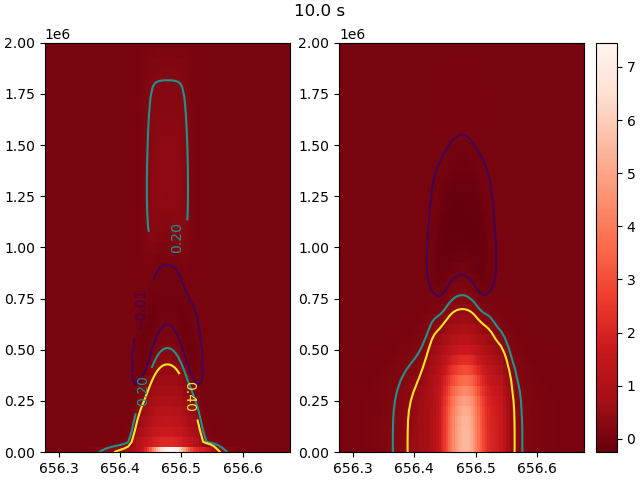

In [8]:
wavelengthEdges = np.concatenate([[0.0], 0.5 * (rad['wavelength'][1:] + rad['wavelength'][:-1]), [rad['wavelength'][-1]]])
xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]])
fig, ax = plt.subplots(1, 2, constrained_layout=True)
idx = 50
def rel_diff(a, b):
    return (a - b) / b
lambda0 = H_6().lines[4].lambda0
deltaLambda = 0.4
waveRange = (656.27, 656.67)
# waveRange = (121.4, 121.8)
# waveRange = (854.344, 854.544)

waveRange = (lambda0 - 0.5*deltaLambda, lambda0 + 0.5*deltaLambda)
waveIdxs = [np.searchsorted(rad['wavelength'], w) for w in waveRange]
sl = rel_diff(Iverts[idx], Iverts[idx][:, -1][:, None])[waveIdxs[0]:waveIdxs[1]]
vmin = sl.min()
vmax = sl.max()
slb = rel_diff(Itilt[idx], Itilt[idx][:, -1][:, None])[waveIdxs[0]:waveIdxs[1]]
vmin = min(vmin, slb.min())
vmaxb = max(vmax, slb.max())

contourLevels = [-0.01, 0.2, 0.4]
# contourLevels = [c*300 for c in contourLevels]

rd1 = rel_diff(Iverts[idx], Iverts[idx][:, -1][:, None]).T
mesh = ax[0].pcolormesh(wavelengthEdges, xEdges, rd1, vmin=vmin, vmax=vmax, cmap='Reds_r')
cs1 = ax[0].contour(rad['wavelength'], rad['xAxis'], rd1, contourLevels, cmap='viridis')
ax[0].clabel(cs1, inline=True)

rd2 = rel_diff(Itilt[idx], Itilt[idx][:, -1][:, None]).T
ax[1].pcolormesh(wavelengthEdges, xEdges, rd2, vmin=vmin, vmax=vmax, cmap='Reds_r')
cs2 = ax[1].contour(rad['wavelength'], rad['xAxis'], rd2, contourLevels, cmap='viridis')
fig.colorbar(mesh)
fig.suptitle(f'{rad["time"][idx]} s')

for a in ax:
    a.set_xlim(*waveRange)

In [ ]:
waveIdxs

In [ ]:
ctx = make_ctx(50, mus=mus)
ctx.formal_sol()
Itilt20 = np.copy(ctx.spect.I)

In [ ]:
# with open('F10_flat_Itilt.pickle', 'wb') as pkl:
#     pickle.dump({'Itilt': Itilt}, pkl)

In [ ]:
plt.figure()
idx= 50
# plt.plot(ctx.spect.wavelength, (Itilt[idx][:, :] - rad['I'][idx][:, 1, :]) / Itilt[idx])
plt.plot(ctx.spect.wavelength, rad['I'][idx][:, 1], '--')
plt.xlim(656.271, 656.671)
# plt.xlim(854.244, 854.644)
# plt.ylim(-0.1, 0.1)

In [ ]:
rad['xAxis'][14]

In [ ]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X - 1)**2 - (Y - 1)**2)
Z = (Z1 - Z2) * 2

In [ ]:
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')

In [ ]:
list(pops.keys())

In [103]:
from matplotlib.colors import LogNorm
def plot_h_pops(tIdx, pops):
    def rel_diff(a, b):
        return (b - a) / b
    zN = pops['zAxis'][tIdx]
    z0 = pops['zAxis'][0]
    zEdges = np.concatenate([[zN[0]], 0.5 * (zN[1:] + zN[:-1]), [zN[-1]]]) / 1e6
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]]) / 1e6
    fig, ax = plt.subplots(1, 2)
    hPops = pops['H'][tIdx].reshape(-1, 450, 41)
    hPops0 = pops['H'][0].reshape(-1, 450, 41)
    h0Interp = np.zeros_like(hPops0)
    for i in range(hPops0.shape[0]):
        for x in range(rad['xAxis'].shape[0]):
            h0Interp[i, :, x] = weno4(zN, z0, hPops0[i, :, x])
    rd1 = rel_diff(h0Interp[1], hPops[1])
    rd2 = rel_diff(h0Interp[2], hPops[2])
    
    vmin = min(rd1.min(), rd2.min())
    vmax = max(rd1.max(), rd2.max())
    
    maxAmp = max(abs(vmin), abs(vmax))
    vmin = -maxAmp
    vmax = maxAmp
    
    mesh = ax[0].pcolormesh(xEdges, zEdges, rd1, norm=SymLogNorm(linthresh=1e-1, vmin=vmin, vmax=vmax), cmap='RdBu_r')
#     ax[1].pcolormesh(xEdges, zEdges, pops['H'][tIdx].reshape(-1, 450, 41)[2], norm=LogNorm())
    ax[1].pcolormesh(xEdges, zEdges, rd2, norm=SymLogNorm(linthresh=1e-1, vmin=vmin, vmax=vmax), cmap='RdBu_r')
    for a in ax:
        a.set_ylim(None, 2)
    fig.colorbar(mesh)
    fig.suptitle(f'{pops["time"][tIdx]} s')

<ipython-input-103-dff7344b8315>:31: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(mesh)


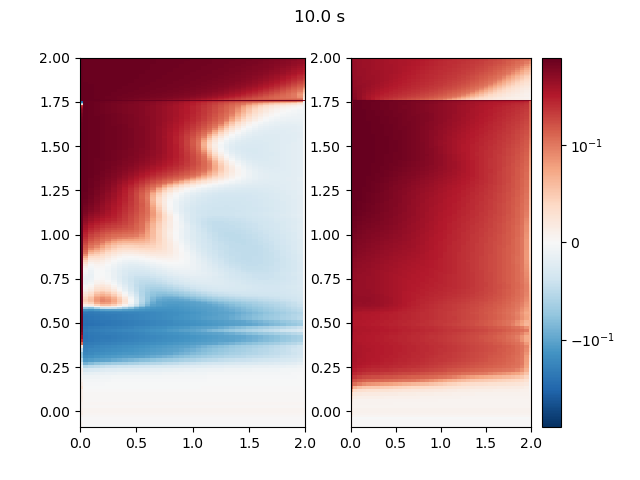

In [104]:
plot_h_pops(50, popsF9)

In [ ]:
CaII().lines[-1].i

In [ ]:
def plot_ca_pops(tIdx, pops):
    def rel_diff(a, b):
        return (b - a) / b
    zN = pops['zAxis'][tIdx]
    z0 = pops['zAxis'][0]
    zEdges = np.concatenate([[zN[0]], 0.5 * (zN[1:] + zN[:-1]), [zN[-1]]]) / 1e6
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]]) / 1e6
    fig, ax = plt.subplots(1, 2)
    hPops = pops['Ca'][tIdx].reshape(-1, 450, 41)
    hPops0 = pops['Ca'][0].reshape(-1, 450, 41)
    h0Interp = np.zeros_like(hPops0)
    for i in range(hPops0.shape[0]):
        for x in range(rad['xAxis'].shape[0]):
            h0Interp[i, :, x] = weno4(zN, z0, hPops0[i, :, x])
    rd1 = rel_diff(h0Interp[2], hPops[2])
    rd2 = rel_diff(h0Interp[4], hPops[4])
    
    vmin = min(rd1.min(), rd2.min())
    vmax = max(rd1.max(), rd2.max())
    
    maxAmp = max(abs(vmin), abs(vmax))
    vmin = -maxAmp
    vmax = maxAmp
    
    mesh = ax[0].pcolormesh(xEdges, zEdges, rd1, norm=SymLogNorm(linthresh=1e-1, vmin=vmin, vmax=vmax), cmap='RdBu_r')
#     ax[1].pcolormesh(xEdges, zEdges, pops['H'][tIdx].reshape(-1, 450, 41)[2], norm=LogNorm())
    ax[1].pcolormesh(xEdges, zEdges, rd2, norm=SymLogNorm(linthresh=1e-1, vmin=vmin, vmax=vmax), cmap='RdBu_r')
    for a in ax:
        a.set_ylim(None, 2)
    fig.colorbar(mesh)
    fig.suptitle(f'{pops["time"][tIdx]} s')

In [ ]:
plot_ca_pops(50, popsF9)

In [9]:
def compute_tau(ctx, mu):
    upDown = 1
    tau = np.zeros_like(ctx.depthData.chi[:, mu, upDown, :])
    chi = ctx.depthData.chi
    atmos = ctx.kwargs['atmos']

    # NOTE(cmo): Compute tau for all wavelengths
    tau[:, 0] = 1e-20
    for k in range(1, tau.shape[1]):
        tau[:, k] = tau[:, k-1] + 0.5 * (chi[:, mu, upDown, k] + chi[:, mu, upDown, k-1]) \
                                      * (atmos.height[k-1] - atmos.height[k]) / atmos.muz[mu]
    return tau

In [10]:
def load_1d_atmos(tIdx, xIdx, atmost, pops):
    time = pops['time'][tIdx]
    atmostIdx = np.searchsorted(atmost.time, time)
    zN = np.copy(pops['zAxis'][tIdx, :])
    nHTotRadyn = atmost.d1 / (lw.DefaultAtomicAbundance.massPerH * lw.Amu)
    if xIdx != 0:
        atmos = lw.Atmosphere.make_1d(scale=lw.ScaleType.Geometric,
                                      depthScale=zN,
                                      temperature=weno4(zN, atmost.z1[0], atmost.tg1[0]),
                                      vlos=np.zeros(450), 
                                      vturb=np.ones(450)*2e3,
                                      nHTot=np.ones(450) * weno4(zN, atmost.z1[0], nHTotRadyn[0]),
                                      ne=np.copy(pops['ne'][tIdx].reshape(450, 41)[:, xIdx]))
    else:
        raise NotImplementedError()
    return atmos

def make_1d_ctx(tIdx, xIdx, atmost, pops, mus=None):
    atmos = load_1d_atmos(tIdx, xIdx, atmost, pops)
    if mus is None:
        atmos.rays(muz=1.0, wmu=[1.0])
    else:
        atmos.rays(**mus)
    FchromaAtoms = [H_6(), CaII(), He_9_atom(), C_atom(), O_atom(), Si_atom(), Fe_atom(),
                    MgII_atom(), N_atom(), Na_atom(), S_atom()]
    aSet = lw.RadiativeSet(FchromaAtoms)
    aSet.set_active('H', 'Ca')
    spect = aSet.compute_wavelength_grid()
    eqPops = aSet.compute_eq_pops(atmos)
    for ele in ['H', 'Ca']:
        aPop = eqPops[ele]
        aPop[:] = pops[ele][tIdx].reshape(-1, 450, 41)[:, :, xIdx]
    atmos.hPops = eqPops['H']
    atmos.bHeat = np.zeros(450)

    ctx = lw.Context(atmos, spect, eqPops, Nthreads=8, backgroundProvider=FastBackground)
    ctx.depthData.fill = True
        
    return ctx

In [11]:
def compute_taus_cfns(tIdx, atmost, pops):
    tauList = []
    cfnList = []
    for xIdx in tqdm(range(1, 41)):
        ctx = make_1d_ctx(tIdx, xIdx, atmost, pops)
        while True:
            dJ = ctx.formal_sol_gamma_matrices().dJMax
            if dJ < 1e-3:
                break
        tau = compute_tau(ctx, -1)
        cfn = lw.compute_contribution_fn(ctx, -1)
        tauList.append(tau)
        cfnList.append(cfn)
    taus = np.stack(tauList).transpose(1, 2, 0)
    cfns = np.stack(cfnList).transpose(1, 2, 0)
    return taus, cfns
taus, cfns = compute_taus_cfns(50, atmost, pops)
taus0, cfns0 = compute_taus_cfns(0, atmost, pops)

100%|██████████| 40/40 [00:47<00:00,  1.20s/it]


In [12]:
from matplotlib.colors import LinearSegmentedColormap, SymLogNorm
def scale_cfn(cfn, scaleLimits=None):
    cfnLog = cfn
    if scaleLimits is None:
        minVal = np.min(cfnLog[np.isfinite(cfnLog)])
        maxVal = np.max(cfnLog[np.isfinite(cfnLog)])
    else:
        minVal = scaleLimits[0]
        maxVal = scaleLimits[1]
    cfnLog = np.clip(cfnLog, minVal, maxVal)
    return cfnLog

def plot_core_cfn(tIdx, cfns):
    def rel_diff(a, b):
        return (b - a) / b
    zN = pops['zAxis'][tIdx]
    z0 = pops['zAxis'][0]
    zEdges = np.concatenate([[zN[0]], 0.5 * (zN[1:] + zN[:-1]), [zN[-1]]]) / 1e6
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]]) / 1e6
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 6))
    
    cfnLog = scale_cfn(cfns)
#     cfnLog = cfns0
    
    hWlIdx = np.searchsorted(rad['wavelength'], H_6().lines[4].lambda0)
    hWlIdx2 = np.searchsorted(rad['wavelength'], H_6().lines[4].lambda0 + 0.03)
    hWlIdx3 = np.searchsorted(rad['wavelength'], H_6().lines[4].lambda0 + 0.05)
    caWlIdx = np.searchsorted(rad['wavelength'], CaII().lines[-1].lambda0)
    caWlIdx2 = np.searchsorted(rad['wavelength'], CaII().lines[-1].lambda0 + 0.015)
    caWlIdx3 = np.searchsorted(rad['wavelength'], CaII().lines[-1].lambda0 + 0.02)
#     vmin=1e-20
    maxVal = max(
        cfnLog[hWlIdx].max(), cfnLog[caWlIdx].max(),
        cfnLog[hWlIdx2].max(), cfnLog[caWlIdx2].max(),
        cfnLog[hWlIdx3].max(), cfnLog[caWlIdx3].max(),
    )
    
    myReds = LinearSegmentedColormap.from_list(name='MyReds', colors=[(0.0, 0.0, 0.0, 0.0), (1.0, 0.0, 0.0, 1.0)])
    myBlues = LinearSegmentedColormap.from_list(name='MyBlues', colors=[(0.0, 0.0, 0.0, 0.0), (0.0, 0.0, 1.0, 1.0)])
    myGreens = LinearSegmentedColormap.from_list(name='MyGreens', colors=[(0.0, 0.0, 0.0, 0.0), (0.0, 1.0, 0.0, 1.0)])
    plt.register_cmap(cmap=myReds)
    plt.register_cmap(cmap=myBlues)
    plt.register_cmap(cmap=myGreens)
    
    mesh = ax[0].pcolormesh(xEdges[1:], zEdges, cfnLog[hWlIdx], cmap='MyBlues', norm=SymLogNorm(linthresh=1e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
    ax[0].pcolormesh(xEdges[1:], zEdges, cfnLog[hWlIdx2], cmap='MyReds', norm=SymLogNorm(linthresh=1e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
    ax[0].pcolormesh(xEdges[1:], zEdges, cfnLog[hWlIdx3], cmap='MyGreens', norm=SymLogNorm(linthresh=1e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
    ax[1].pcolormesh(xEdges[1:], zEdges, cfnLog[caWlIdx], cmap='MyBlues', norm=SymLogNorm(linthresh=1e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
    ax[1].pcolormesh(xEdges[1:], zEdges, cfnLog[caWlIdx2], cmap='MyReds', norm=SymLogNorm(linthresh=1e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
    ax[1].pcolormesh(xEdges[1:], zEdges, cfnLog[caWlIdx3], cmap='MyGreens', norm=SymLogNorm(linthresh=1e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
    for a in ax:
        a.set_ylim(None, 2)
        a.set_xlim(0, 2)
    for a in ax[1:]:
        a.set_yticklabels([])
    fig.colorbar(mesh)
    fig.suptitle(f'{pops["time"][tIdx]} s')

<ipython-input-16-c6a70d5d5a93>:57: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(mesh)


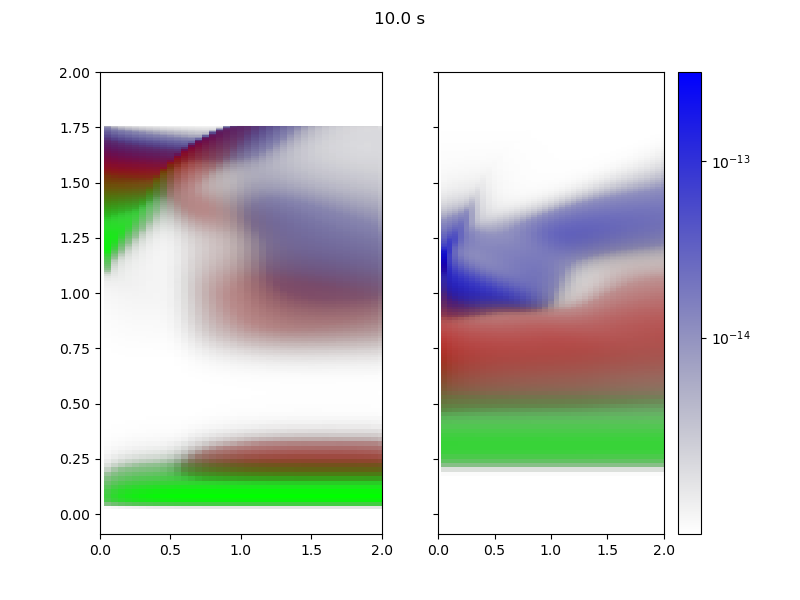

In [17]:
plot_core_cfn(50, cfns)

In [ ]:
            
def plot_core_change_cfn(tIdx, cfns, cfn0):
    def rel_diff(a, b):
        return (a - b) / a
    zN = pops['zAxis'][tIdx]
    z0 = pops['zAxis'][0]
    zEdges = np.concatenate([[zN[0]], 0.5 * (zN[1:] + zN[:-1]), [zN[-1]]]) / 1e6
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]]) / 1e6
    
    fig, ax = plt.subplots(1, 2)
    
    cfnLog = scale_cfn(cfns)
    cfn0Log = scale_cfn(cfn0)
    cfn0Interp = np.zeros_like(cfn0)
    for i in range(cfn0.shape[0]):
        for x in range(cfn0.shape[2]):
            cfn0Interp[i, :, x] = weno4(zN, z0, cfn0Log[i, :, x])
    
    hWlIdx = np.searchsorted(rad['wavelength'], H_6().lines[4].lambda0)
    caWlIdx = np.searchsorted(rad['wavelength'], CaII().lines[-1].lambda0)
#     vmin=1e-20
    maxVal = max(cfnLog[hWlIdx].max(), cfnLog[caWlIdx].max())
    
#     mesh = ax[0].pcolormesh(xEdges[1:], zEdges, cfn0Interp[hWlIdx], cmap='Blues', norm=SymLogNorm(linthresh=5e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
#     ax[1].pcolormesh(xEdges[1:], zEdges, cfn0Interp[caWlIdx], cmap='Blues', norm=SymLogNorm(linthresh=5e-14, vmin=1e-20, vmax=maxVal), rasterized=True)
    mesh = ax[0].pcolormesh(xEdges[1:], zEdges, cfnLog[hWlIdx], cfn0Interp[hWlIdx]), cmap='Blues', rasterized=True, norm=LogNorm())
    ax[1].pcolormesh(xEdges[1:], zEdges, rel_diff(cfnLog[caWlIdx], cfn0Interp[caWlIdx]), cmap='Blues', rasterized=True, norm=LogNorm())
    for a in ax:
        a.set_ylim(None, 2)
        a.set_xlim(0, 2)
    ax[1].set_yticklabels([])
    fig.colorbar(mesh)
    fig.suptitle(f'{pops["time"][tIdx]} s')

In [ ]:
plot_core_change_cfn(50, cfns, cfns0)

In [13]:
from matplotlib.colors import LogNorm
from matplotlib.image import NonUniformImage
def tau1_line_2d(tau, z):
    tau1 = np.zeros((tau.shape[0], tau.shape[2]))

    for la in range(tau.shape[0]):
        for x in range(tau.shape[2]):
            tau1[la, x] = weno4(1.0, tau[la, :, x], z)

    return tau1

def plot_coco_cfn(tIdx, cfns, taus, taus0, pops, rad, title):
    def rel_diff(a, b):
        return (b - a) / b
    zN = pops['zAxis'][tIdx]
    z0 = pops['zAxis'][0]
    zEdges = np.concatenate([[zN[0]], 0.5 * (zN[1:] + zN[:-1]), [zN[-1]]]) / 1e6
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]]) / 1e6
    
    fig, ax = plt.subplots(1, 4, figsize=(10, 4), constrained_layout=True)
    
#     cfnLog = scale_cfn(cfns)
    cfnLog = cfns
#     cfnLog = cfns0
    wave = rad['wavelength'][:]
    lineColors = ['c', 'm', 'y']
    xAxis = rad['xAxis'][:]
    
    hLambda0 = H_6().lines[4].lambda0
    caLambda0 = CaII().lines[-1].lambda0
    offsets = [0.0, 0.03, 0.05, 0.0, 0.015, 0.02]
    means = np.array([hLambda0, hLambda0 + 0.03, hLambda0 + 0.05, caLambda0, caLambda0 + 0.015, caLambda0 + 0.02])
    stds = np.array([0.01, 0.01, 0.01, 0.005, 0.003, 0.003])
    amps = 1.0 / (np.sqrt(2.0 * np.pi) * stds)
    filt = amps[None, :] * np.exp(-0.5 * ((wave[:, None] - means[None, :]) / stds[None, :])**2) 
    channels = np.tensordot(filt, cfns, axes=(0,0))
    channels = np.log10(channels)
    thresh = -11.5
    channels[channels < thresh] = thresh
    channels[:3] -= channels[:3].min()
    channels[:3] /= channels[:3].max()
    channels[3:] -= channels[3:].min()
    channels[3:] /= channels[3:].max()
    
    im1 = channels[:3]
    c = np.array([0.0, 1.0, 1.0])[:, None, None]
    m = np.array([1.0, 0.0, 1.0])[:, None, None]
    y = np.array([1.0, 1.0, 0.0])[:, None, None]
    
    def tonemap(c, mode='aces', Gamma=2.2):
        # http://filmicworlds.com/blog/filmic-tonemapping-operators/
        if mode == 'reinhard':
            c = c / (1.0 + c)
            return c**(1.0 / Gamma)
        elif mode == 'uncharted2':
            A = 0.15
            B = 0.50
            C = 0.10
            D = 0.20
            E = 0.02
            F = 0.30
            W = 11.2
            bias = 2.0
            mapper = lambda c: ((c*(A*c+C*B)+D*E)/(c*(A*c+B)+D*F))-E/F
            curr = mapper(c * bias)
            whiteScale = 1.0 / mapper(W)
            return (curr * whiteScale)**(1.0 / Gamma)
        elif mode == 'aces':
            # https://github.com/TheRealMJP/BakingLab/blob/master/BakingLab/ACES.hlsl
            # https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
            # https://therealmjp.github.io/posts/sg-series-part-6-step-into-the-baking-lab/
            acesIn = np.array([[0.59719, 0.35458, 0.04823],
                               [0.07600, 0.90834, 0.01566],
                               [0.02840, 0.13383, 0.83777]])
            acesOut = np.array([[1.60475, -0.53108, -0.07367],
                                [-0.10208,  1.10813, -0.00605],
                                [-0.00327, -0.07276,  1.07602]])
            bias = 0.8
            
            def RRTAndODTFit(v):
                # RRT: Reference rendering transform
                # ODT: Output display transform
                a = v * (v + 0.0245786) - 0.000090537;
                b = v * (0.983729 * v + 0.4329510) + 0.238081;
                return a / b
            
            def LinearTosRGB(color):
                x = color * 12.92
                y = 1.055 * np.clip(color, 0.0, 1.0)**(1.0 / 2.4) - 0.055

                clr = color;
                clr[0] = np.where(color[0] < 0.0031308, x[0], y[0])
                clr[1] = np.where(color[1] < 0.0031308, x[1], y[1])
                clr[2] = np.where(color[2] < 0.0031308, x[2], y[2])
                return clr
            
            color = np.tensordot(acesIn, c, axes=(0, 0))
            color = RRTAndODTFit(color)
            color = np.tensordot(acesOut, color, axes=(0, 0))
            color = np.clip(color, 0.0, 1.0)
            color = LinearTosRGB(color * bias)
            color = np.clip(color, 0.0, 1.0)
            return color
        elif mode == 'linear':
            c = np.clip(c, 0.0, 1.0)
            return c**(1.0 / Gamma)
        else:
            raise NotImplementedError()
    
    # https://github.com/matplotlib/matplotlib/issues/4277
    mode = 'aces'
    Gamma = 2.2
    channels[:3] = channels[0] * c + channels[1] * m + channels[2] * y
    channels[:3] = tonemap(channels[:3], mode=mode, Gamma=Gamma)
    
    channels[3:] = channels[3] * c + channels[4] * m + channels[5] * y
    channels[3:] = tonemap(channels[3:], mode=mode, Gamma=Gamma)
    
    colorTuplesH = np.array([channels[i].flatten() for i in range(3)] + [np.ones_like(channels[0].flatten())]).transpose()
    colorTuplesCa = np.array([channels[i].flatten() for i in range(3, 6)]).transpose()
    
    # Has weird artifacts when zoomed, using NonUniformImage instead
#     mesh = ax[0].pcolormesh(xEdges[1:], zEdges, channels[0], facecolor=colorTuplesH, rasterized=True, antialiased=True, edgecolors='face', snap=True)
# #     mesh = ax[0].pcolormesh(xAxis[1:] / 1e6, zEdges[1:], channels[0], color=colorTuplesH, rasterized=True, antialiased=True, edgecolors='face', snap=True, shading='gouraud')
#     mesh.set_array(None) # avoids weird artifacts *shrug*
#     mesh = ax[2].pcolormesh(xEdges[1:], zEdges, channels[3], color=colorTuplesCa, rasterized=True, antialiased=True, edgecolors='face', snap=True)
#     mesh.set_array(None)
    
    # Add a white first column
    channels = np.concatenate([np.ones((channels.shape[0], channels.shape[1], 1)), channels], axis=-1)
    im = NonUniformImage(ax[0], interpolation='nearest', extent=(xAxis[1] / 1e6, xAxis[-1] / 1e6, zN[-1], 2.0))
    zMaxIdx = np.argwhere(zN < 2.00e6).squeeze()[0] - 2
    im.set_data(xAxis / 1e6, zN[-1:zMaxIdx:-1] / 1e6, channels[:3].transpose(1, 2, 0)[-1:zMaxIdx:-1, :, :])
    # This breaks constrained_layout, but we can ignore it in the layout step
    im.set_in_layout(False)
    ax[0].add_image(im)
    
    im = NonUniformImage(ax[2], interpolation='nearest', extent=(xAxis[1] / 1e6, xAxis[-1] / 1e6, zN[-1] / 1e-6, 2.0))
    im.set_data(xAxis / 1e6, zN[-1:zMaxIdx:-1] / 1e6, channels[3:].transpose(1, 2, 0)[-1:zMaxIdx:-1, :, :])
    im.set_in_layout(False)
    ax[2].add_image(im)
    
    ha = H_6().lines[4]
    nj = pops['H'][tIdx][ha.j].reshape(450, 41)
    ni = pops['H'][tIdx][ha.i].reshape(450, 41)
    haSfn = nj * ha.Aji / (ni * ha.Bij - nj * ha.Bji)
    ax[1].pcolormesh(xEdges, zEdges, haSfn, norm=LogNorm(), rasterized=True, antialiased=True)
    
    ca = CaII().lines[-1]
    nj = pops['Ca'][tIdx][ca.j].reshape(450, 41)
    ni = pops['Ca'][tIdx][ca.i].reshape(450, 41)
    caSfn = nj * ca.Aji / (ni * ca.Bij - nj * ca.Bji)
    ax[3].pcolormesh(xEdges, zEdges, caSfn, norm=LogNorm(), rasterized=True, antialiased=True)
    
    waveIdxs = [np.searchsorted(wave, m) for m in means]
    tau1 = tau1_line_2d(taus, zN)
    for a in ax[:2]:
        for idx, color, offset in zip(waveIdxs[:3], lineColors, offsets[:3]):
            a.plot(xAxis[1:] / 1e6, tau1[idx] / 1e6, c=color, label=f'+{offset:.03f} nm')
    for a in ax[2:]:
        for idx, color, offset in zip(waveIdxs[3:], lineColors, offsets[3:]):
            a.plot(xAxis[1:] / 1e6, tau1[idx] / 1e6, c=color, label=f'+{offset:.03f} nm')
    for a in [ax[0], ax[2]]:
        leg = a.legend(frameon=False, handletextpad=0, handlelength=0)
        legLines = leg.get_lines()
        for line in legLines:
            line.set_linestyle(' ')
            
        for handle, label in zip(leg.legendHandles, leg.texts):
            label.set_color(handle.get_color())
    
    tau1_0 = tau1_line_2d(taus0, zN)
    for a in ax[:2]:
        for idx, color in zip(waveIdxs[:3], lineColors):
            a.plot(xAxis[1:] / 1e6, tau1_0[idx] / 1e6, '--', c=color)
    for a in ax[2:]:
        for idx, color in zip(waveIdxs[3:], lineColors):
            a.plot(xAxis[1:] / 1e6, tau1_0[idx] / 1e6, '--', c=color)

    for a in ax:
        a.set_ylim(zN[-1] / 1e6, 2)
        a.set_xlim(0, 2)
        a.set_xlabel('$x$ [Mm]')
    for a in ax[1:]:
        a.set_yticklabels([])
        a.tick_params('y', direction='in')
    ax[0].set_title(r'$C_I$: H$\alpha$')
    ax[1].set_title(r'$S$: H$\alpha$')
    ax[2].set_title('$C_I$: Ca ɪɪ 854.2 nm')
    ax[3].set_title('$S$: Ca ɪɪ 854.2 nm')
    ax[0].set_ylabel('$z$ [Mm]')
    fig.suptitle(f'{title}: $t={pops["time"][tIdx]:.0f}$ s')
    return fig


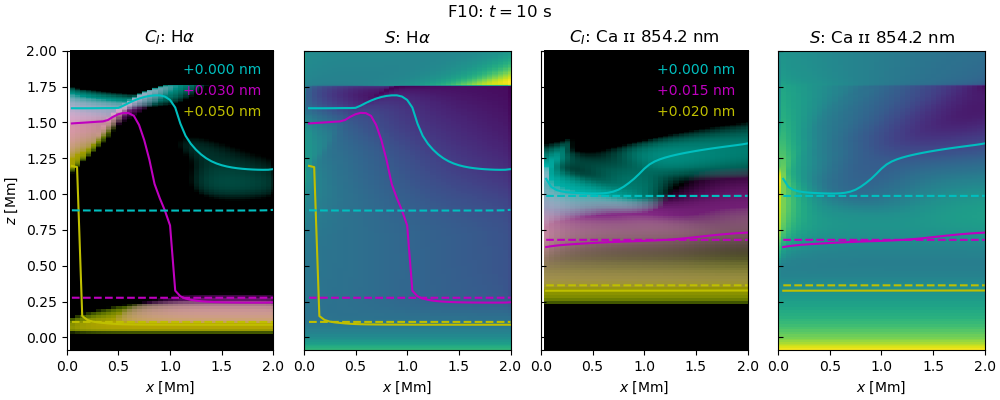

In [14]:
fig = plot_coco_cfn(50, cfns, taus, taus0, pops, rad, 'F10')
# fig.savefig('F10_cococo.pdf', dpi=400)

In [ ]:
zN = pops['zAxis'][50]
idx = np.argwhere(zN < 2.00e6).squeeze()[0] - 2
zN[-1:idx:-1]

In [18]:
tausF9, cfnsF9 = compute_taus_cfns(50, atmostF9, popsF9)
taus0F9, cfns0F9 = compute_taus_cfns(0, atmostF9, popsF9)

100%|██████████| 40/40 [00:47<00:00,  1.18s/it]


In [ ]:
fig = plot_coco_cfn(50, cfnsF9, tausF9, taus0F9, popsF9, radF9, 'F9')
fig.savefig('F9_cococo.pdf', dpi=400)

In [15]:
def plot_sfn_enhance(tIdx, pops, rad, taus, taus0):
    zN = pops['zAxis'][tIdx][:]
    z0 = pops['zAxis'][0][:]
    tau1 = tau1_line_2d(taus, zN)
    tau1_0 = tau1_line_2d(taus0, z0)
    
    ha = H_6().lines[4]
    nj = pops['H'][tIdx][ha.j].reshape(450, 41)
    ni = pops['H'][tIdx][ha.i].reshape(450, 41)
    haSfn = nj * ha.Aji / (ni * ha.Bij - nj * ha.Bji)
    nj = pops['H'][0][ha.j].reshape(450, 41)
    ni = pops['H'][0][ha.i].reshape(450, 41)
    haSfn0 = nj * ha.Aji / (ni * ha.Bij - nj * ha.Bji)
    
    ca = CaII().lines[-1]
    nj = pops['Ca'][tIdx][ca.j].reshape(450, 41)
    ni = pops['Ca'][tIdx][ca.i].reshape(450, 41)
    caSfn = nj * ca.Aji / (ni * ca.Bij - nj * ca.Bji)
    nj = pops['Ca'][0][ca.j].reshape(450, 41)
    ni = pops['Ca'][0][ca.i].reshape(450, 41)
    caSfn0 = nj * ca.Aji / (ni * ca.Bij - nj * ca.Bji)
    
    means = np.array([ha.lambda0, ha.lambda0 + 0.03, ha.lambda0 + 0.05])
    meansCa = np.array([ca.lambda0, ca.lambda0 + 0.015, ca.lambda0 + 0.02])
    
    xAxis = pops['xAxis'][:]
    wave = rad['wavelength'][:]
    waveIdxs = [np.searchsorted(wave, m) for m in means]
    waveIdxsCa = [np.searchsorted(wave, m) for m in meansCa]
    haSfnLine = np.zeros((means.shape[0], 41))
    haSfn0Line = np.zeros((means.shape[0], 41))
    caSfnLine = np.zeros((means.shape[0], 41))
    caSfn0Line = np.zeros((means.shape[0], 41))

    for i, idx in enumerate(waveIdxs):
        for x in range(1, 41):
            haSfnLine[i, x] = weno4(tau1[idx, x-1], zN, haSfn[:, x])
            haSfn0Line[i, x] = weno4(tau1_0[idx, x-1], z0, haSfn0[:, x])
            caSfnLine[i, x] = weno4(tau1[idx, x-1], zN, caSfn[:, x])
            caSfn0Line[i, x] = weno4(tau1_0[idx, x-1], z0, caSfn0[:, x])
            
    fig, ax = plt.subplots(1, 2, figsize=(5, 3.5), constrained_layout=True)
    for i, c in zip(range(means.shape[0]), ['c', 'm', 'y']):
        ax[0].plot(xAxis[1:] / 1e6, haSfnLine[i, 1:], c=c, label=f'+{means[i] - means[0]:.03f} nm')
        ax[0].plot(xAxis[1:] / 1e6, haSfn0Line[i, 1:], '--', c=c)
        
        ax[1].plot(xAxis[1:] / 1e6, caSfnLine[i, 1:], c=c, label=f'+{meansCa[i] - meansCa[0]:.03f} nm')
        ax[1].plot(xAxis[1:] / 1e6, caSfn0Line[i, 1:], '--', c=c)
    for a in ax:
        leg = a.legend(frameon=False, handletextpad=0, handlelength=0)
        legLines = leg.get_lines()
        for line in legLines:
            line.set_linestyle(' ')
            
        for handle, label in zip(leg.legendHandles, leg.texts):
            label.set_color(handle.get_color())
        
    for a in ax:
        a.set_xlabel('$x$ [Mm]')
        a.set_ylim(0.5e-8, 5.5e-8)
    ax[0].set_ylabel(r'$S(\tau_\nu=1)$ [SI]')
    ax[1].set_yticklabels([])
    ax[1].tick_params('y', direction='in')
    ax[0].set_title(r'H$\alpha$')
    ax[1].set_title('Ca ɪɪ 854.2 nm')
    return fig

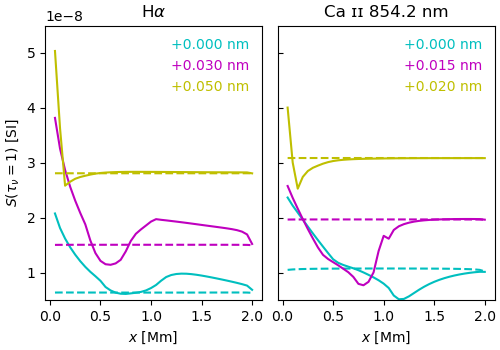

In [16]:
fig = plot_sfn_enhance(50, pops, rad, taus, taus0)
fig.savefig('F10_Sfn.pdf')

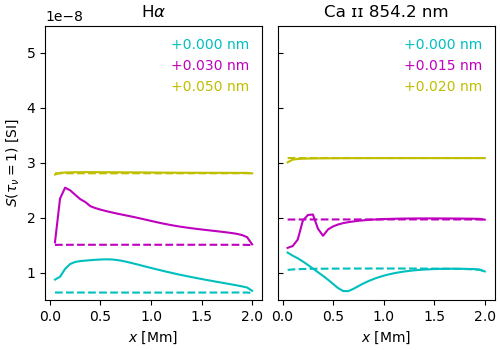

In [19]:
fig = plot_sfn_enhance(50, popsF9, radF9, tausF9, taus0F9)
fig.savefig('F9_Sfn.pdf')

In [ ]:
plt.figure()


In [20]:
def plot_rel_level_pops_chi(tIdx, pops, rad, taus, title):
    zN = pops['zAxis'][tIdx][:]
    z0 = pops['zAxis'][0][:]
    tau1 = tau1_line_2d(taus, zN)
    
    xAxis = pops['xAxis'][:]
    
    ha = H_6().lines[4]
    nj = pops['H'][tIdx][ha.j].reshape(450, 41)
    ni = pops['H'][tIdx][ha.i].reshape(450, 41)
    nj0 = pops['H'][0][ha.j].reshape(450, 41)
    ni0 = pops['H'][0][ha.i].reshape(450, 41)
    n0 = pops['H'][tIdx][0].reshape(450, 41)
    n00 = pops['H'][0][0].reshape(450, 41)
    waveIdx = np.searchsorted(rad['wavelength'], ha.lambda0) 
    
    
    njz = np.zeros(41)
    niz = np.zeros(41)
    njz0 = np.zeros(41)
    niz0 = np.zeros(41)
    n0z = np.zeros(41)
    n0z0 = np.zeros(41)
    for x in range(1, 41):
        njz[x] = weno4(tau1[waveIdx, x-1], zN, nj[:, x])
        niz[x] = weno4(tau1[waveIdx, x-1], zN, ni[:, x])
        njz0[x] = weno4(tau1[waveIdx, x-1], z0, nj0[:, x])
        niz0[x] = weno4(tau1[waveIdx, x-1], z0, ni0[:, x])
        n0z[x] = weno4(tau1[waveIdx, x-1], zN, n0[:, x])
        n0z0[x] = weno4(tau1[waveIdx, x-1], z0, n00[:, x])
        
    fig, ax = plt.subplots(1, 2, figsize=(5, 3.5), constrained_layout=True)
    ax[0].semilogy(xAxis[1:] / 1e6, n0z[1:], c='C0', label='H (n=1)')
    ax[0].semilogy(xAxis[1:] / 1e6, n0z0[1:], '--', c='C0')
    ax[0].semilogy(xAxis[1:] / 1e6, niz[1:], c='C1', label='H (n=2)')
    ax[0].semilogy(xAxis[1:] / 1e6, niz0[1:], '--', c='C1')
    ax[0].semilogy(xAxis[1:] / 1e6, njz[1:], c='C2', label='H (n=3)')
    ax[0].semilogy(xAxis[1:] / 1e6, njz0[1:], '--', c='C2')
    leg = ax[0].legend(frameon=False, handletextpad=0, handlelength=0)
    legLines = leg.get_lines()
    for line in legLines:
        line.set_linestyle(' ')

    for handle, label in zip(leg.legendHandles, leg.texts):
        label.set_color(handle.get_color())
    
    ax[1].semilogy(xAxis[1:] / 1e6, (niz * ha.Bij - njz * ha.Bji)[1:], c='C0')
    ax[1].semilogy(xAxis[1:] / 1e6, (niz0 * ha.Bij - njz0 * ha.Bji)[1:], '--', c='C0')
    ax[0].set_ylabel(r'Number Density [m$^{-3}$]')
    ax[1].set_ylabel(r'$\chi$ [m$^{-1}$]')
    for a in ax:
        a.set_xlabel('$x$ [Mm]')
    fig.suptitle(title)
    
    return fig

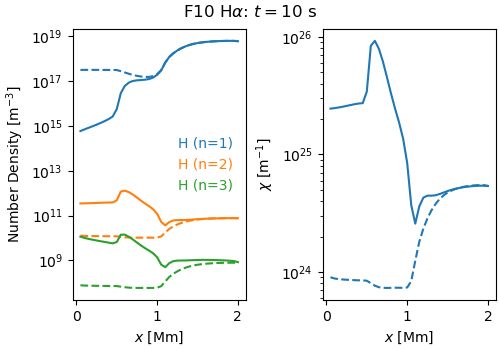

In [21]:
fig = plot_rel_level_pops_chi(50, pops, rad, taus, title=r'F10 H$\alpha$: $t=10$ s')
# fig.savefig('F10_rel_pops_chi.pdf')

In [44]:
from matplotlib.colors import LogNorm, SymLogNorm
def plot_ne(fig, ax, tIdx, pops, title, left=True):
    zN = pops['zAxis'][tIdx][:]
    xAxis = pops['xAxis'][:]
    zEdges = np.concatenate([[zN[0]], 0.5 * (zN[1:] + zN[:-1]), [zN[-1]]]) / 1e6
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]]) / 1e6
    ne = pops['ne'][tIdx][:]
    
    mesh = ax.pcolormesh(xEdges, zEdges, ne.reshape(zN.shape[0], xAxis.shape[0]), norm=LogNorm(), cmap='inferno', rasterized=True)
    ax.set_ylim(None, 2)
    ax.set_title(f'{title}: $t=${pops["time"][tIdx]:.1f} s')
    if left:
        ax.set_ylabel('$z$ [Mm]')
    else:
        ax.set_yticklabels([])
        ax.tick_params('y', direction='in')
        fig.colorbar(mesh)
        
    ax.set_xlabel('$x$ [Mm]')

def plot_ne_ratio(fig, ax, tIdx, popsA, popsB, title, left=True):
    zN = pops['zAxis'][tIdx][:]
    xAxis = pops['xAxis'][:]
    zEdges = np.concatenate([[zN[0]], 0.5 * (zN[1:] + zN[:-1]), [zN[-1]]]) / 1e6
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]]) / 1e6
    neA = popsA['ne'][tIdx][:]
    neB = popsB['ne'][tIdx][:]
    
    mesh = ax.pcolormesh(
        xEdges, 
        zEdges, 
        neA.reshape(zN.shape[0], xAxis.shape[0]) / neB.reshape(zN.shape[0], xAxis.shape[0]), 
        norm=SimLogNorm(linthresh=1e-2), 
        cmap='inferno', 
        rasterized=True
    )
    ax.set_ylim(None, 2)
    ax.set_title(f'{title}: $t=${pops["time"][tIdx]:.1f} s')
    if left:
        ax.set_ylabel('$z$ [Mm]')
    else:
        ax.set_yticklabels([])
        ax.tick_params('y', direction='in')
        fig.colorbar(mesh)
        
    ax.set_xlabel('$x$ [Mm]')

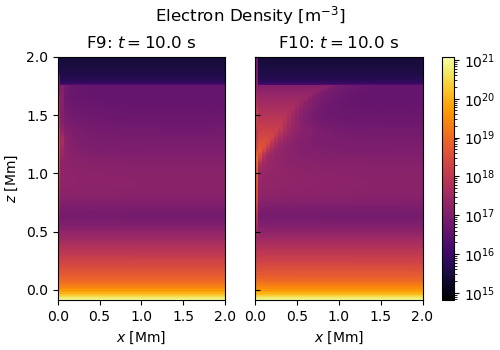

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(5, 3.5), constrained_layout=True)
plot_ne(fig, ax[0], 50, popsF9, title='F9')
plot_ne(fig, ax[1], 50, pops, title='F10', left=False)
fig.suptitle('Electron Density [m$^{-3}$]')
fig.savefig('Nes.pdf', dpi=400)

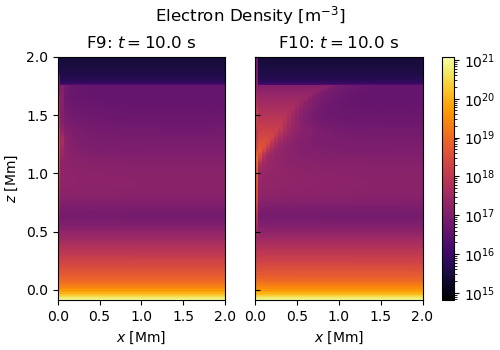

In [45]:
fig = plt.figure(figsize=(5, 3.5), constrained_layout=True)
ax = fig.gca()
plot_ne_ratio(fig, ax[0], 50, popsF9, title='')
fig.suptitle('Electron Density Ratio')
# fig.savefig('Nes.pdf', dpi=400)

In [17]:
statEq = zarr.convenience.open('F9_flat_450_41_StatEqUpdated_t15_1stColCopyTrue_besser_MsLw2d_thesis.zip', 'r')

In [18]:
def load_stat_eq_atmos(pops, atmost, time=10.0):
    tIdx = 1
    atmostIdx = np.searchsorted(atmost.time, time)
    zN = np.copy(pops['SimOutput/zAxis'][tIdx, :])
    atmos = lw.Atmosphere.make_2d(height=zN, x=np.copy(pops['SimParams/xAxis'][...]),
                                  temperature=np.ones((450, 41)) * weno4(zN, atmost.z1[0], atmost.tg1[0])[:, None],
                                  vx=np.zeros((450, 41)),
                                  vz=np.zeros((450, 41)), 
                                  vturb=np.ones((450, 41))*2e3,
                                  nHTot=pops['SimOutput/Populations/NLTE/H'][tIdx].sum(axis=0).reshape(450, 41),
                                  ne=np.copy(pops['SimOutput/ne'][tIdx, ...]),
                                  xLowerBc=FixedXBc('lower'),
                                  xUpperBc=FixedXBc('upper'))
    atmos2d = atmos.dimensioned_view()
    atmos2d.temperature[:, 0] = weno4(zN, atmost.z1[atmostIdx], atmost.tg1[atmostIdx])
    atmos2d.vz[:, 0] = weno4(zN, atmost.z1[atmostIdx], atmost.vz1[atmostIdx])
    return atmos

def make_vert_stat_eq_ctx(pops, atmost, time=10.0):
    atmos = load_stat_eq_atmos(pops, atmost, time=time)
    atmos.rays(muz=1.0, wmu=[1.0])
    tIdx = 2
    
    FchromaAtoms = [H_6(), CaII(), He_9_atom(), C_atom(), O_atom(), Si_atom(), Fe_atom(),
                    MgII_atom(), N_atom(), Na_atom(), S_atom()]
    aSet = lw.RadiativeSet(FchromaAtoms)
    aSet.set_active('H', 'Ca')
    spect = aSet.compute_wavelength_grid()
    eqPops = aSet.compute_eq_pops(atmos)
    for ele in ['H', 'Ca']:
        aPop = eqPops[ele]
        aPop[:] = pops[f'SimOutput/Populations/NLTE/{ele}'][tIdx]
        aPop2d = aPop.reshape(-1, 450, 41)

    ctx = lw.Context(atmos, spect, eqPops, Nthreads=12, backgroundProvider=FastBackground)
    atmos.xLowerBc.set_bc(np.zeros((spect.wavelength.shape[0], 450)))
    atmos.xUpperBc.set_bc(np.zeros((spect.wavelength.shape[0], 450)))
        
    return ctx

In [31]:
ctxSe = make_vert_stat_eq_ctx(statEq, atmostF9, time=15.0)
ctxSe.formal_sol()

IterationUpdate(ctx=<lightweaver.Context object at 0x7fcb6c0c1490>, crsw=1.0, updatedJ=False, dJMax=0.0, dJMaxIdx=0, updatedPops=False, dPops=[], dPopsMaxIdx=[], ngAccelerated=False, updatedNe=False, dNeMax=0.0, dNeMaxIdx=0, updatedRho=False, NprdSubIter=0, dRho=[], dRhoMaxIdx=[], updatedJPrd=False, dJPrdMax=[], dJPrdMaxIdx=[])

In [25]:
ctxSe.spect.I[:, 0]

array([3.48459313e-17, 1.56360196e-16, 5.38558966e-16, ...,
       6.89160841e-09, 6.94300548e-09, 6.98986052e-09])

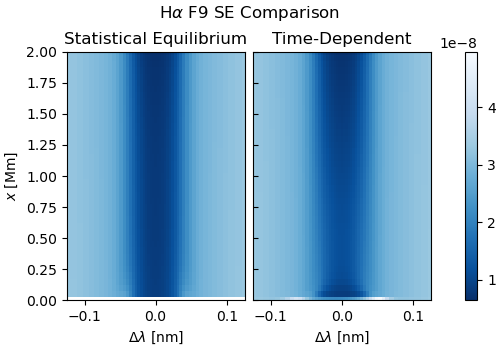

In [25]:
def plot_Iverts_se_comp(Ise, Iverts, lambda0, deltaLambda, figsize=(5, 3.5), title=r'F10 H$\alpha$', time=10.0):
    wavelengthEdges = np.concatenate([[0.0], 0.5 * (rad['wavelength'][1:] + rad['wavelength'][:-1]), [rad['wavelength'][-1]]])
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]])
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=figsize)
    
    waveRange = (-0.5*deltaLambda, 0.5*deltaLambda)
    waveIdxs = [np.searchsorted(rad['wavelength'], lambda0 + w) for w in waveRange]

    
    tIdx = np.searchsorted(rad['time'][:], time)
    
    waveSlice = slice(waveIdxs[0], waveIdxs[1])
    td = Iverts[tIdx]
    se = Ise
    vmin = min(td[waveSlice].min(), se[waveSlice].min())
    vmax = max(td[waveSlice].max(), se[waveSlice].max())
    
    ax[0].pcolormesh(wavelengthEdges - lambda0, xEdges / 1e6, se.T, cmap='Blues_r', rasterized=True, vmin=vmin, vmax=vmax)
    mesh = ax[1].pcolormesh(wavelengthEdges - lambda0, xEdges / 1e6, td.T, cmap='Blues_r', rasterized=True, vmin=vmin, vmax=vmax)
    ax[0].set_title('Statistical Equilibrium')
    ax[1].set_title('Time-Dependent')
        
    ax[0].set_ylabel('$x$ [Mm]')
    for a in ax[1:]:
        a.set_yticklabels([])
        a.tick_params('y', direction='in')
    fig.colorbar(mesh)

    for a in ax:
        a.set_xlim(*waveRange)
        a.set_xlabel(r'$\Delta\lambda$ [nm]')
    fig.suptitle(title)
    return fig
        
fig = plot_Iverts_se_comp(ctxSe.spect.I, IvertsF9,
                          lambda0=H_6().lines[4].lambda0, 
                          deltaLambda=0.25,
                          title=r'H$\alpha$ F9 SE Comparison')
# fig.savefig('F9_SeComp_Ha', dpi=400)

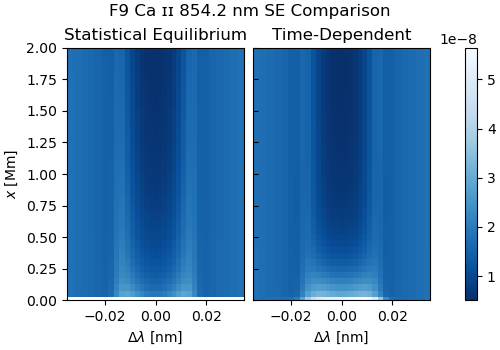

In [26]:
fig = plot_Iverts_se_comp(ctxSe.spect.I, IvertsF9,
                          lambda0=CaII().lines[-1].lambda0, 
                          deltaLambda=0.07,
                          title=r'F9 Ca ɪɪ 854.2 nm SE Comparison')
# fig.savefig('F9_SeComp_8542', dpi=400)


In [24]:
statEq15FixNe = zarr.convenience.open('F9_flat_450_41_StatEqUpdated_LoadNe_t15_1stColCopy_besser_MsLw2d_thesis.zip', 'r')
ctxSeFixNe = make_vert_stat_eq_ctx(statEq15FixNe, atmostF9, time=15.0)
ctxSeFixNe.formal_sol()

IterationUpdate(ctx=<lightweaver.Context object at 0x7fcb6c0c2110>, crsw=1.0, updatedJ=False, dJMax=0.0, dJMaxIdx=0, updatedPops=False, dPops=[], dPopsMaxIdx=[], ngAccelerated=False, updatedNe=False, dNeMax=0.0, dNeMaxIdx=0, updatedRho=False, NprdSubIter=0, dRho=[], dRhoMaxIdx=[], updatedJPrd=False, dJPrdMax=[], dJPrdMaxIdx=[])

In [22]:
fig = plot_Iverts_se_comp(ctxSeFixNe.spect.I, IvertsF9,
                          lambda0=CaII().lines[-1].lambda0, 
                          deltaLambda=0.07,
                          time=15.0,
                          title=r'F9 Ca ɪɪ 854.2 nm Fixed $n_e$ Comparison')
# fig.savefig('F9_SeCompFixNe_8542', dpi=400)

NameError: name 'plot_Iverts_se_comp' is not defined

In [23]:
fig = plot_Iverts_se_comp(ctxSeFixNe.spect.I, IvertsF9,
                          lambda0=H_6().lines[4].lambda0, 
                          deltaLambda=0.25,
                          time=15.0,
                          title=r'F9 H$\alpha$ Fixed $n_e$ Comparison')
# fig.savefig('F9_SeCompFixNe_Ha', dpi=400)

NameError: name 'plot_Iverts_se_comp' is not defined

In [15]:
def plot_Iverts_se_comp_fix(Ise, IseFix, Iverts, lambda0, deltaLambda, figsize=(5, 3), title=r'F10 H$\alpha$', time=10.0):
    wavelengthEdges = np.concatenate([[0.0], 0.5 * (rad['wavelength'][1:] + rad['wavelength'][:-1]), [rad['wavelength'][-1]]])
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]])
    fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=figsize)
    
    waveRange = (-0.5*deltaLambda, 0.5*deltaLambda)
    waveIdxs = [np.searchsorted(rad['wavelength'], lambda0 + w) for w in waveRange]

    
    tIdx = np.searchsorted(rad['time'][:], time)
    
    waveSlice = slice(waveIdxs[0], waveIdxs[1])
    td = Iverts[tIdx]
    se = Ise
    seFix = IseFix
    vmin = min(td[waveSlice].min(), se[waveSlice].min(), seFix[waveSlice].min())
    vmax = max(td[waveSlice].max(), se[waveSlice].max(), seFix[waveSlice].max())
    
    ax[0].pcolormesh(wavelengthEdges - lambda0, xEdges / 1e6, se.T, cmap='Blues_r', rasterized=True, vmin=vmin, vmax=vmax)
    mesh = ax[1].pcolormesh(wavelengthEdges - lambda0, xEdges / 1e6, seFix.T, cmap='Blues_r', rasterized=True, vmin=vmin, vmax=vmax)
    mesh = ax[2].pcolormesh(wavelengthEdges - lambda0, xEdges / 1e6, td.T, cmap='Blues_r', rasterized=True, vmin=vmin, vmax=vmax)
    ax[0].set_title('SE')
    ax[1].set_title('SE Fix')
    ax[2].set_title('TD')
        
    ax[0].set_ylabel('$x$ [Mm]')
    for a in ax[1:]:
        a.set_yticklabels([])
        a.tick_params('y', direction='in')
    fig.colorbar(mesh)

    for a in ax:
        a.set_xlim(*waveRange)
        a.set_ylim(None, 1.0)
        a.set_xlabel(r'$\Delta\lambda$ [nm]')
    if title is not None:
        fig.suptitle(title)
    return fig

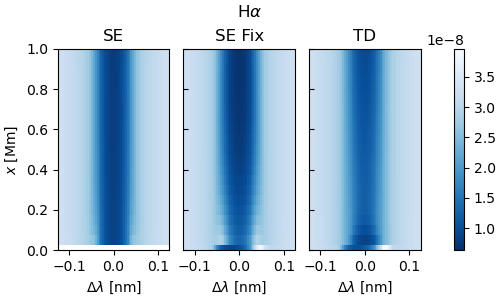

In [32]:
fig = plot_Iverts_se_comp_fix(ctxSe.spect.I, ctxSeFixNe.spect.I, IvertsF9,
                              lambda0=H_6().lines[4].lambda0, 
                              deltaLambda=0.25,
                              time=15.0,
                              title=r'H$\alpha$')
# fig.savefig('F9_15_Ha_SeComp.pdf', dpi=400)

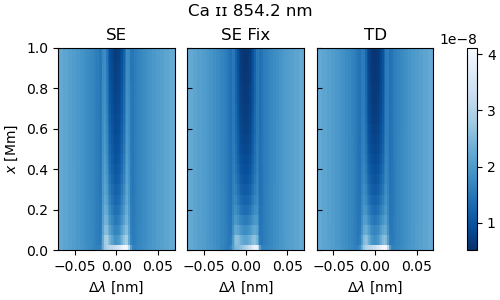

In [40]:
fig = plot_Iverts_se_comp_fix(ctxSe.spect.I, ctxSeFixNe.spect.I, IvertsF9,
                              lambda0=CaII().lines[-1].lambda0, 
                              deltaLambda=0.14,
                              time=15.0,
                              title='Ca ɪɪ 854.2 nm')
# fig.savefig('F9_15_8542_SeComp.pdf', dpi=400)

In [39]:
def plot_Iverts_se_comp_fix_slices(Ise, IseFix, Iverts, 
                                   lambda0, deltaLambda, 
                                   figsize=(5, 3), title=r'F10 H$\alpha$', time=10.0,
                                   slice_idxs=[1, 3, 5, 8]):
    wavelengthEdges = np.concatenate([[0.0], 0.5 * (rad['wavelength'][1:] + rad['wavelength'][:-1]), [rad['wavelength'][-1]]])
    xEdges = np.concatenate([[0.0], 0.5 * (rad['xAxis'][1:] + rad['xAxis'][:-1]), [rad['xAxis'][-1]]])
    fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=figsize)
    
    waveRange = (-0.5*deltaLambda, 0.5*deltaLambda)
    waveIdxs = [np.searchsorted(rad['wavelength'], lambda0 + w) for w in waveRange]

    
    tIdx = np.searchsorted(rad['time'][:], time)
    
    waveSlice = slice(waveIdxs[0], waveIdxs[1])
    td = Iverts[tIdx]
    se = Ise
    seFix = IseFix
    vmin = min(td[waveSlice].min(), se[waveSlice].min(), seFix[waveSlice].min())
    vmax = max(td[waveSlice].max(), se[waveSlice].max(), seFix[waveSlice].max())
    
    for sl_idx in slice_idxs:
        ax[0].plot(rad['wavelength'][...] - lambda0, se[:, sl_idx], alpha=0.8, label=f"{rad['xAxis'][sl_idx] / 1e3:.0f} km")
        ax[1].plot(rad['wavelength'][...] - lambda0, seFix[:, sl_idx], alpha=0.8)
        ax[2].plot(rad['wavelength'][...] - lambda0, td[:, sl_idx], alpha=0.8)
    ax[0].set_title('SE')
    ax[1].set_title('SE Fix')
    ax[2].set_title('TD')
        
    ax[0].set_ylabel('Specific Intensity [SI]')
    for a in ax[1:]:
        a.set_yticklabels([])
        a.tick_params('y', direction='in')
#     fig.colorbar(mesh)

    for a in ax:
        a.set_xlim(*waveRange)
#         a.set_ylim(None, 1.0)
        a.set_ylim(0.5 * vmin, 1.2 * vmax)
        a.set_xlabel(r'$\Delta\lambda$ [nm]')
        
    leg = ax[0].legend(frameon=False, handletextpad=0, handlelength=0, labelspacing=0.3, loc='upper center')
    
        
    legLines = leg.get_lines()
    for line in legLines:
        line.set_linestyle(' ')

    for handle, label in zip(leg.legendHandles, leg.texts):
        label.set_color(handle.get_color())
        
    if title is not None:
        fig.suptitle(title)
    return fig

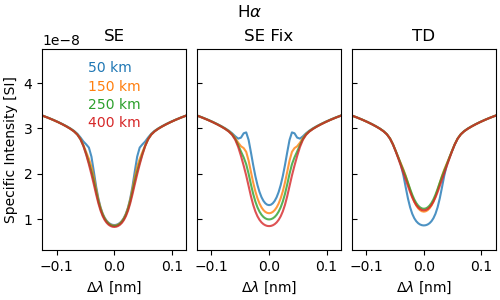

In [42]:

fig = plot_Iverts_se_comp_fix_slices(ctxSe.spect.I, ctxSeFixNe.spect.I, IvertsF9,
                              lambda0=H_6().lines[4].lambda0, 
                              deltaLambda=0.25,
                              time=15.0,
                              title=r'H$\alpha$')
fig.savefig('F9_15_Ha_SeComp_Slices.pdf')
# line skip

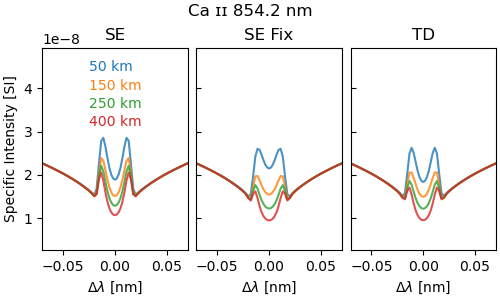

In [43]:
fig = plot_Iverts_se_comp_fix_slices(ctxSe.spect.I, ctxSeFixNe.spect.I, IvertsF9,
                              lambda0=CaII().lines[-1].lambda0, 
                              deltaLambda=0.14,
                              time=15.0,
                              title='Ca ɪɪ 854.2 nm')
fig.savefig('F9_15_8542_SeComp_Slices.pdf')